In [1]:
#Importing all the requires libraries
import pandas as pd
from collections import Counter
import tensorflow 
import numpy as np
from matplotlib import pyplot as pp
import seaborn as sb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,precision_recall_curve, average_precision_score,roc_curve, RocCurveDisplay, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_0 = pd.read_csv('healthcare-dataset-stroke-data.xls')
data = pd.DataFrame(data_0) #preserving an unedited copy of the dataset
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.columns #Displaying columns for reference in lower cells

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
#preprocessing the data, such as creating dummies for categorical data and so forth.

#data = pd.get_dummies(data,columns=['gender'],dtype='int64')

for n,i in data.iterrows():#Checking the other types of gender present in data and their count
    if i['gender'] != 'Male' and i['gender'] != 'Female':
        print(i['gender'])

#Only one row with gender Other. better to drop that row altogether to get better dummies

data = data[data['gender'] != 'Other']
data = pd.get_dummies(data,columns=['gender','Residence_type','work_type','smoking_status','ever_married'],dtype='int64')
data.drop(columns=['id'],axis=1) #ID is useless as a feature
data.columns

Other


Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'Residence_type_Rural',
       'Residence_type_Urban', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'ever_married_No', 'ever_married_Yes'],
      dtype='object')

In [5]:
#There are 201 missing values in BMI.
print("Count of missing values:\n")
print(data.isna().sum())

#Now we could just fill it with mean or median values, or just remove the rows with missing BMI. But we are going to use regression to fill the BMI values.
#We will use the entire feature count except bmi as X to predict bmi as a Y. Then take the rows with missing BMI as the testing data.
#Finally we will append the predicted BMI values into testing data and add that back into our final data, which will now have 0 missing entries
train = data[~data['bmi'].isna()]
test = data[data['bmi'].isna()]

X_train = train.drop(columns=['bmi'])
y_train = train['bmi']

X_test = test.drop(columns=['bmi'])

model = RandomForestRegressor()
model.fit(X_train,y_train)
print()
print("The R2 score for this model is",model.score(X_train,y_train))

missing_BMI_values = model.predict(X_test)
X_test['bmi'] = missing_BMI_values

Count of missing values:

id                                  0
age                                 0
hypertension                        0
heart_disease                       0
avg_glucose_level                   0
bmi                               201
stroke                              0
gender_Female                       0
gender_Male                         0
Residence_type_Rural                0
Residence_type_Urban                0
work_type_Govt_job                  0
work_type_Never_worked              0
work_type_Private                   0
work_type_Self-employed             0
work_type_children                  0
smoking_status_Unknown              0
smoking_status_formerly smoked      0
smoking_status_never smoked         0
smoking_status_smokes               0
ever_married_No                     0
ever_married_Yes                    0
dtype: int64

The R2 score for this model is 0.8897435485041211


In [6]:
final = pd.concat([train,X_test],ignore_index=True)
final.isna().sum() #Now there are no null values

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Female                     0
gender_Male                       0
Residence_type_Rural              0
Residence_type_Urban              0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
ever_married_No                   0
ever_married_Yes                  0
dtype: int64

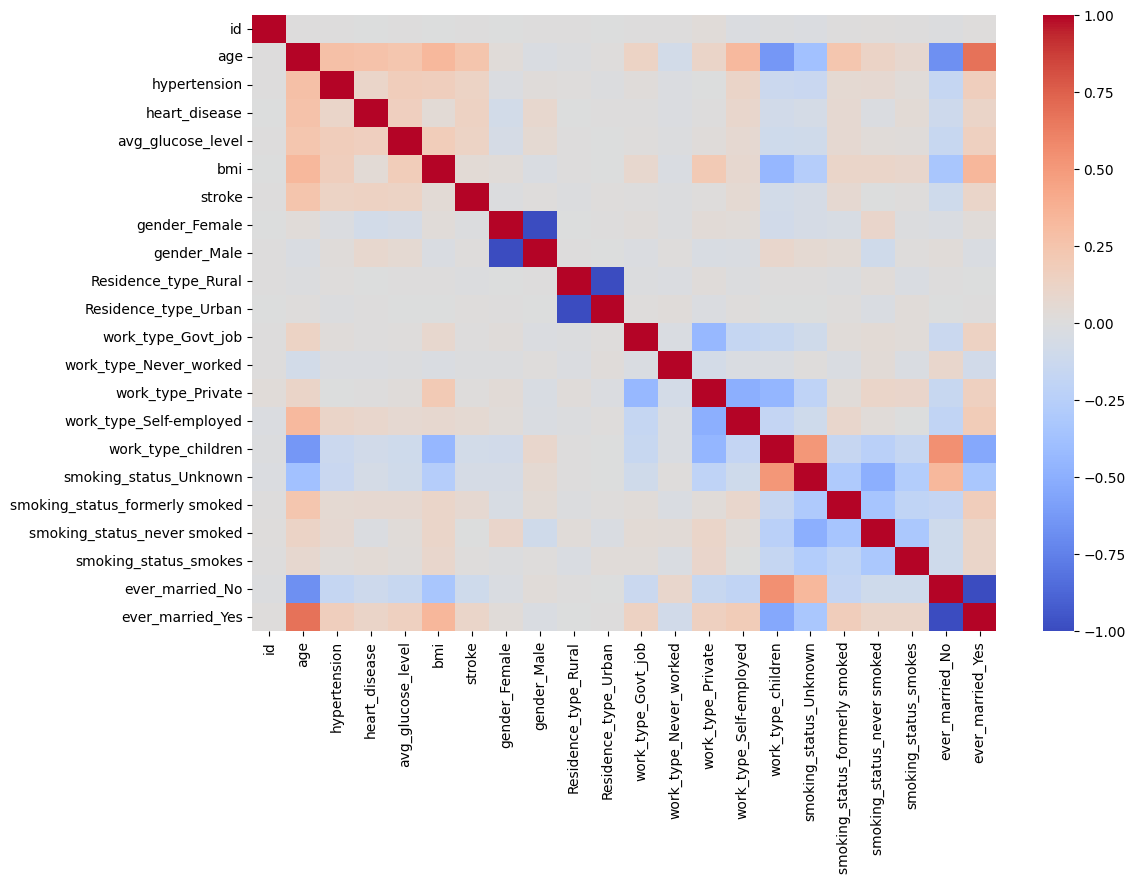

In [7]:
corr = final.corr()
#Checking linear correlation. Although this is not an absolute measure since non linear and complex relationships are not captured
pp.figure(figsize=(12,8))
sb.heatmap(corr,cmap="coolwarm")
pp.show()

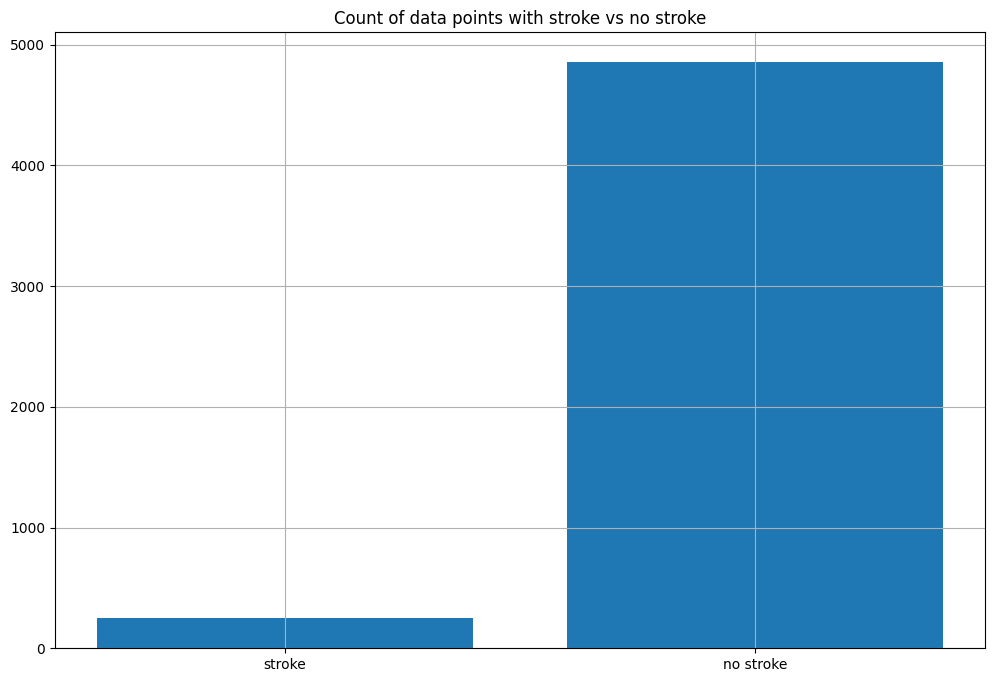

In [8]:
#As we can see, there is heavy class imbalance
pp.figure(figsize=(12,8))
counts = Counter(data['stroke'])
values = list(counts.values())

pp.bar(['stroke','no stroke'],values)
pp.title("Count of data points with stroke vs no stroke")
pp.grid()
pp.show()

<Axes: xlabel='age', ylabel='Density'>

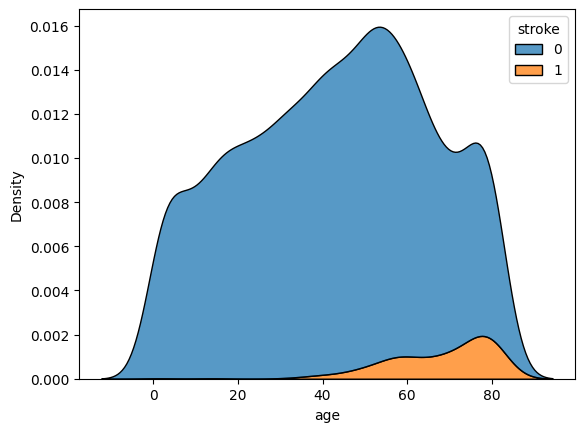

In [9]:
#As expected, most of the stroke occurance density is after the age of 40 up to 80+
sb.kdeplot(x='age',hue='stroke',data=final,multiple='stack')

<Axes: xlabel='bmi', ylabel='Density'>

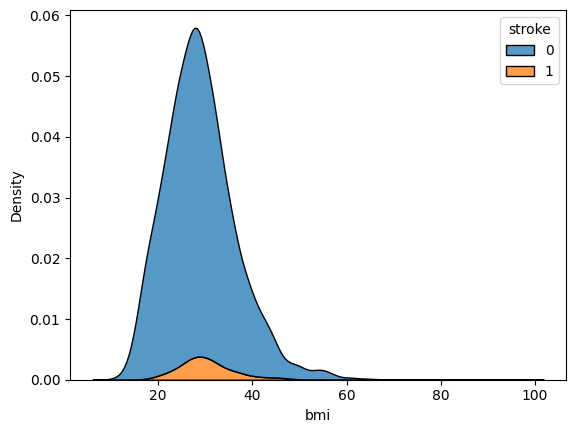

In [10]:
#Stroke occurancy is concentrated among individuals with bmi between 20 to 45 approximately
sb.kdeplot(x='bmi',hue='stroke',data=final,multiple='stack')

In [11]:
X = final.drop(columns=['stroke'])
y = final['stroke']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2) #An 80-20 train test split works fine.


#Since we determined that the dataset has class imbalance, we will make use of SMOTE (Synthetic Minority Oversampling Technique) to address it.
#Of course, we would not apply it to testing data so the resampling is done after splitting the data.
#Oversampling before splitting the data makes it so that the testing data will no longer be unseen by the model, since copies of the rows will exist in both training and testing.
#This will lead to fake high performance by a model.

smote = SMOTE(random_state=69)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#Now, we need to normalize our data, to reduce the effect of large values
#Typically for regression/classification models, Standard Scaler is preferred over min max scaler
scale = StandardScaler()

scale.fit(X_train_re)
X_train_f = pd.DataFrame(scale.transform(X_train_re),columns=X_train_re.columns) #Converting them back into dataframes since training without columns as a numpy array is usually worse
X_test_f = pd.DataFrame(scale.transform(X_test),columns=X_train_re.columns)

In [12]:
#First Model
#For this model, there was a focus on increasing recall for the minority class while also balancing the reducing overall accuracy
#In medical practice, it is obviously better to highlight a person that might have a stroke, regardless of it being true or false 
#Over not highlighting at all. Therefore, accuracy on the minority class matters a lot more than overall accuracy. But we also cannot
#let the model be wildly inaccurate.

model1 = LogisticRegression(C=0.0001,solver='sag',max_iter=5000,random_state=42) #These hyperparameters were tuned manually
model1.fit(X_train_f,y_train_re)
print("The R2 score for the model is:",model1.score(X_train_f,y_train_re)) #To see goodness of fit

y_pred1 = model1.predict(X_test_f)

print(classification_report(y_pred1,y_test))
print("Accuracy score is:",accuracy_score(y_pred1,y_test))

The R2 score for the model is: 0.9128369704749679
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       878
           1       0.39      0.15      0.22       144

    accuracy                           0.85      1022
   macro avg       0.63      0.56      0.57      1022
weighted avg       0.80      0.85      0.82      1022

Accuracy score is: 0.8463796477495108


In [13]:
#Second Model

model2 = MLPClassifier(hidden_layer_sizes=(64, 32, 32, 32), max_iter=3000, random_state=42,solver='adam')
model2.fit(X_train_f,y_train_re)
print("The R2 score for the model is:",model2.score(X_train_f,y_train_re))

y_pred2 = model2.predict(X_test_f)

print(classification_report(y_pred2,y_test))
print("Accuracy score is:",accuracy_score(y_pred2,y_test))

The R2 score for the model is: 0.9962772785622593
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       979
           1       0.19      0.26      0.22        43

    accuracy                           0.92      1022
   macro avg       0.58      0.60      0.59      1022
weighted avg       0.93      0.92      0.93      1022

Accuracy score is: 0.923679060665362


In [14]:
#Third Model

model3 = DecisionTreeClassifier(class_weight='balanced',min_samples_leaf=10,random_state=42)
model3.fit(X_train_f,y_train_re)
print("The R2 score for the model is:",model3.score(X_train_f,y_train_re))

y_pred3 = model3.predict(X_test_f)

print(classification_report(y_pred3,y_test))
print("Accuracy score is:",accuracy_score(y_pred3,y_test))

The R2 score for the model is: 0.962772785622593
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       964
           1       0.21      0.21      0.21        58

    accuracy                           0.91      1022
   macro avg       0.58      0.58      0.58      1022
weighted avg       0.91      0.91      0.91      1022

Accuracy score is: 0.910958904109589


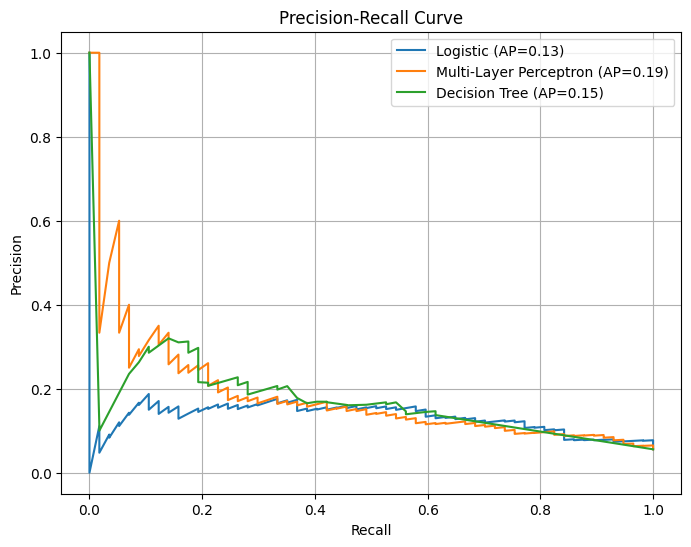

In [15]:
models = {'Logistic' : model1, 'Multi-Layer Perceptron' : model2, 'Decision Tree' : model3}

pp.figure(figsize=(8,6))
for model_name, model in models.items():
    y_probs = model.predict_proba(X_test_f)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    ap = average_precision_score(y_test, y_probs)
    pp.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')

pp.xlabel("Recall")
pp.ylabel("Precision")
pp.title("Precision-Recall Curve")
pp.legend()
pp.grid(True)
pp.show()

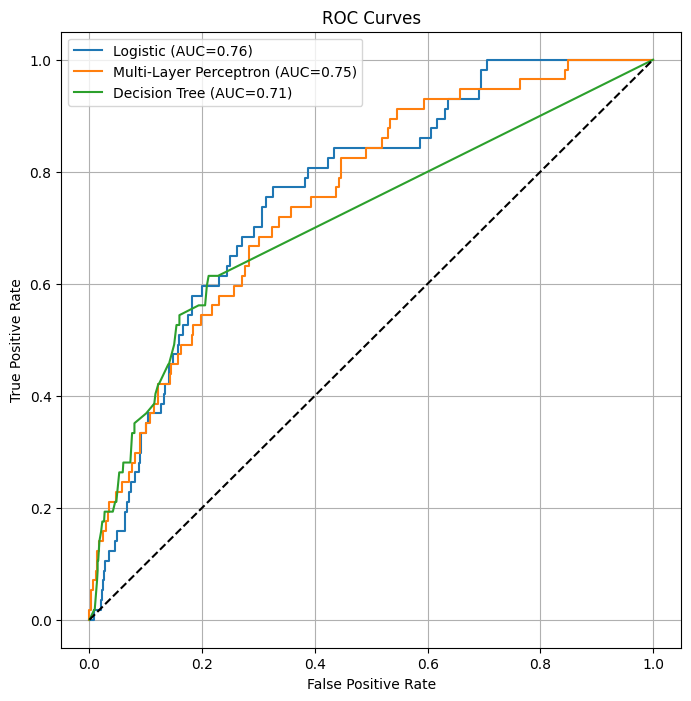

In [16]:
pp.figure(figsize=(8,8))
for model_name, model in models.items():
    y_probs = model.predict_proba(X_test_f)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    pp.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.2f})')

pp.plot([0, 1], [0, 1], 'k--')  # random guess line
pp.xlabel("False Positive Rate")
pp.ylabel("True Positive Rate")
pp.title("ROC Curves")
pp.legend()
pp.grid(True)
pp.show()

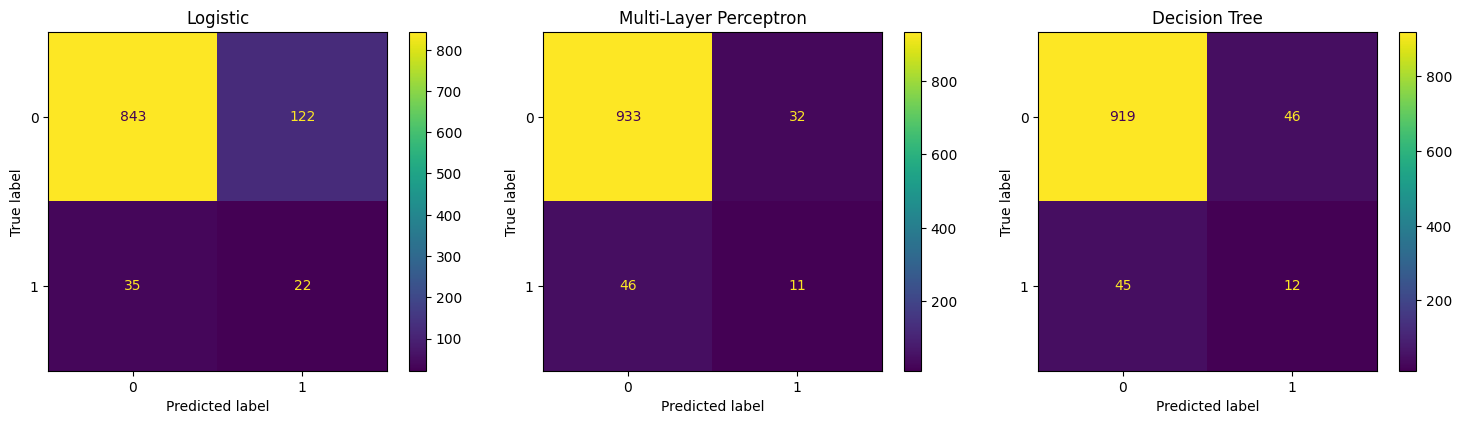

In [17]:

fig, axes = pp.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_f)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax, values_format='d')
    ax.set_title(name)

pp.tight_layout()
pp.show()